In [1]:
! pip install -q transformers

# inference - pipeline

In [3]:
from transformers import pipeline
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pipe = pipeline(task="image-to-image", model="caidas/swin2SR-lightweight-x2-64", device=device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/4.18M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/152 [00:00<?, ?B/s]

(532, 432)


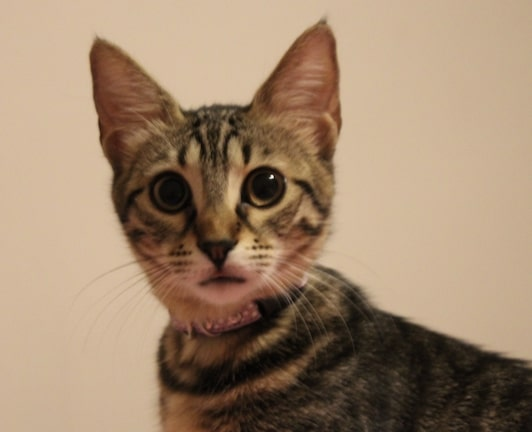

In [7]:
from PIL import Image
import requests

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/cat.jpg"
image = Image.open(requests.get(url, stream=True).raw)

print(image.size)
image

In [8]:
upscaled = pipe(image)
print(upscaled.size)

(1072, 880)


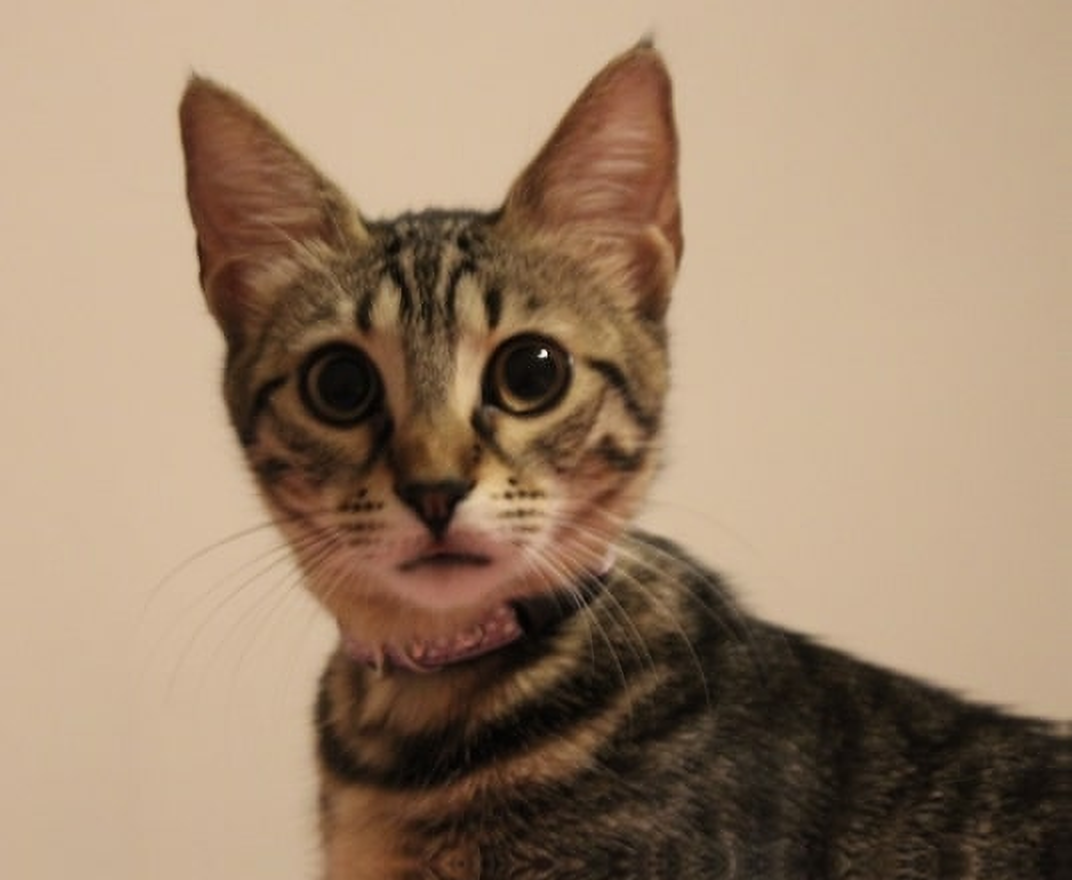

In [9]:
upscaled

# inference - without pipeline

In [10]:
from transformers import Swin2SRForImageSuperResolution, Swin2SRImageProcessor

model = Swin2SRForImageSuperResolution.from_pretrained("caidas/swin2SR-lightweight-x2-64").to(device)
processor = Swin2SRImageProcessor("caidas/swin2SR-lightweight-x2-64")

In [11]:
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

pixel_values = pixel_values.to(device)

torch.Size([1, 3, 440, 536])


In [12]:
import torch

with torch.no_grad():
  outputs = model(pixel_values)

In [15]:
outputs

ImageSuperResolutionOutput(loss=None, reconstruction=tensor([[[[0.8269, 0.8269, 0.8275,  ..., 0.7464, 0.7446, 0.7453],
          [0.8287, 0.8277, 0.8283,  ..., 0.7451, 0.7448, 0.7457],
          [0.8280, 0.8272, 0.8269,  ..., 0.7447, 0.7447, 0.7453],
          ...,
          [0.7923, 0.7924, 0.7918,  ..., 0.1048, 0.1046, 0.1060],
          [0.7927, 0.7926, 0.7931,  ..., 0.1028, 0.1038, 0.1062],
          [0.7937, 0.7917, 0.7929,  ..., 0.1019, 0.1057, 0.1082]],

         [[0.7256, 0.7246, 0.7256,  ..., 0.6521, 0.6512, 0.6523],
          [0.7261, 0.7253, 0.7258,  ..., 0.6513, 0.6506, 0.6514],
          [0.7260, 0.7253, 0.7252,  ..., 0.6515, 0.6505, 0.6505],
          ...,
          [0.6903, 0.6906, 0.6903,  ..., 0.0856, 0.0847, 0.0860],
          [0.6907, 0.6910, 0.6914,  ..., 0.0834, 0.0838, 0.0861],
          [0.6906, 0.6896, 0.6910,  ..., 0.0820, 0.0851, 0.0877]],

         [[0.6285, 0.6277, 0.6287,  ..., 0.5498, 0.5501, 0.5503],
          [0.6278, 0.6277, 0.6290,  ..., 0.5491, 0.5468

In [14]:
outputs.reconstruction.data.shape

torch.Size([1, 3, 880, 1072])

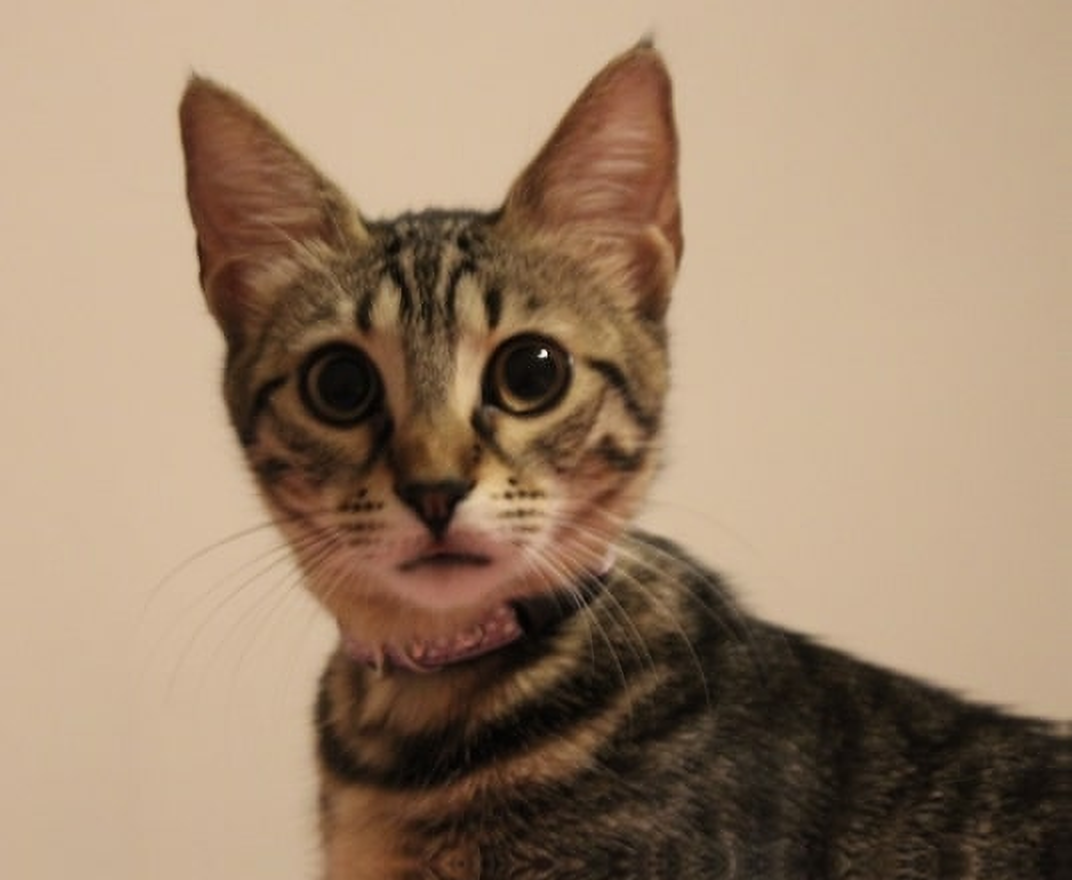

In [16]:
import numpy as np

# squeeze, take to CPU and clip the values
output = outputs.reconstruction.data.squeeze().cpu().clamp_(0, 1).numpy()
# rearrange the axes
output = np.moveaxis(output, source=0, destination=-1)
# bring values back to pixel values range
output = (output * 255.0).round().astype(np.uint8)
Image.fromarray(output)